In [86]:
import pandas as pd
import numpy as np
import json, time, requests, os
import missingno as msno
import matplotlib.pyplot as plt
import geopandas as gpd
from geojson import Point, Feature, FeatureCollection, dump, MultiPolygon

# create a PING noise to let you know modeling is done
from IPython.display import Audio
sound_file = 'glass_ping-Go445-1207030150.mp3'
play_sound = Audio(sound_file, autoplay=True)

In [87]:
import soda_query as sq
%reload_ext autoreload
%autoreload 2

# Ride-Share

#### Loading Data

In [14]:
# gather neighborhood boundaries
community_boundaries = sq.get_community_boundaries()

# gather ridership by neighborhood
%time community_df = sq.get_community_rides()

loading pickle!
loading pickle!
CPU times: user 450 ms, sys: 174 ms, total: 624 ms
Wall time: 629 ms


In [15]:
# gather census tract boundaries
# tract_boundaries = query.get_tract_boundaries() # not needed for now

# gather ridership by census tract
# %time tract_df = query.get_tract_rides() # not needed for now

#### EDA

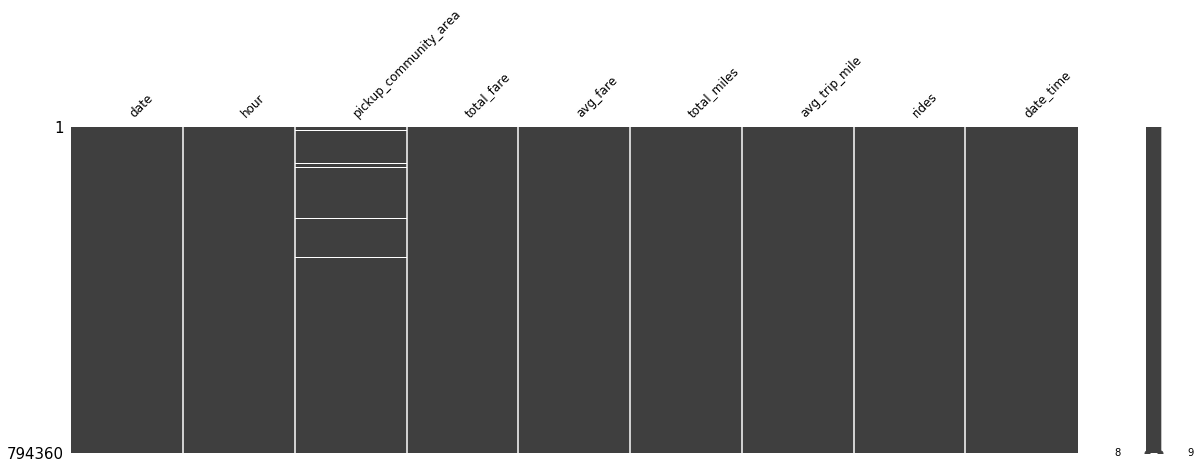

In [18]:
# showing missing data inside df
msno.matrix(community_df, figsize=(20, 6), fontsize=12);

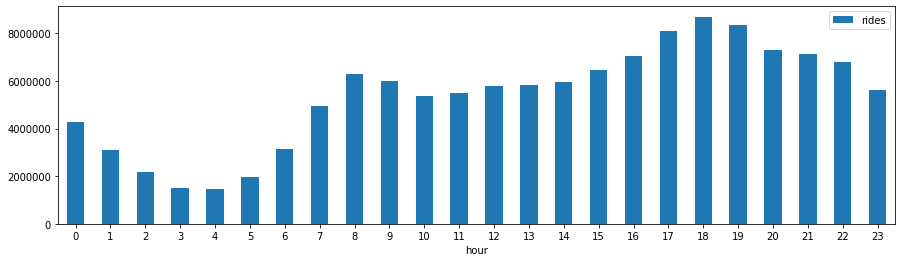

In [19]:
# when are the rides happening?
community_df.groupby('hour').agg({'rides':'sum'}).plot(kind='bar', figsize=(15, 4),)
plt.xticks(rotation=0);

In [20]:
# combine the day with the hour (soda api can't do this???)
community_df['date_time'] = community_df.apply(lambda row: row['date'] + pd.to_timedelta(row['hour'], unit='h'), axis=1)


In [23]:
# double checking the date and times merged correctly (YYYY-MM-DD HH:MM:SS)
community_df.date_time.sample(5)

268663   2019-03-25 05:00:00
354194   2019-05-10 02:00:00
16217    2018-11-09 17:00:00
230234   2019-03-04 14:00:00
759328   2019-12-13 05:00:00
Name: date_time, dtype: datetime64[ns]

In [65]:
# re-group by ridership by hour and pickup - export pickle
community_hour = community_df.groupby(['date_time', 'pickup_community_area']).agg({'rides': 'sum'})
community_hour = community_hour.reset_index()
community_hour.to_pickle('community_hour.pickle')

In [58]:
# showing where rides didn't leave the area they started - DEFUNCT: will need to add dropoff to query
# community_df['same_comm'] = community_df.apply(lambda row: np.where(row['pickup_community_area'] == row['dropoff_community_area'], 1,0), axis=1)

# total = community_df['rides'].sum()
# same_community = community_df.groupby('same_comm').agg({'rides':'sum'})
# same_community = (same_community / total) * 100

# xticks = np.linspace(0,90,10)
# xlabels = [f'{int(x)}%' for x in xticks]

# same_community.plot(kind='bar')
# plt.hlines(same_community.rides[1], -2,2, linestyles='dotted', color='red')
# plt.text(.925,17, '14.5%')
# plt.xticks(ticks=[0,1], labels=['different area'.title(), 'same area'.title()], rotation=0)
# plt.xlabel('Area')
# plt.yticks(ticks=xticks, labels=xlabels)
# plt.ylabel('Percent of All Rides')
# plt.title('Amount of Rides Staying in the Same Community',
#           pad=10);

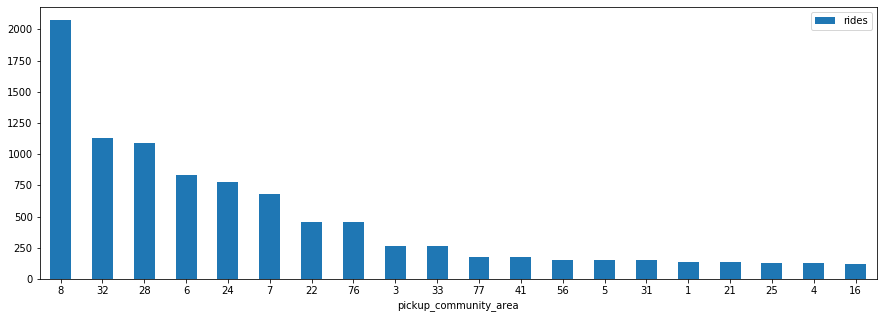

In [24]:
community_df.groupby('pickup_community_area')\
.agg({'rides':'mean'}).sort_values('rides', ascending=False).head(20).plot(kind='bar', figsize=(15,5))
plt.xticks(rotation=0);

In [25]:
community_df['dow'] = community_df['date'].dt.day_name()

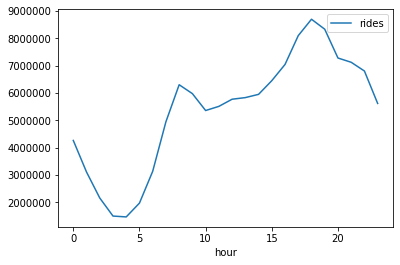

In [26]:
community_df.groupby('hour').agg({'rides':'sum'}).plot()

In [27]:
import seaborn as sns

In [28]:
def plot_dow():
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)

    ax1.p(x[:4], y[:4], s=10, c='b', marker="s", label='first')
    ax1.scatter(x[40:],y[40:], s=10, c='r', marker="o", label='second')
    plt.legend(loc='upper left');
    
    
    for x in community_df['dow'].unique():
        df = community_df[community_df['dow'] == x]
        df = df.groupby('hour').agg({'rides':'sum'}).plot()
        ax1.plot(df.index, df['rides'], label=x)
        
    return plt.show()

In [37]:
community_df[''] = community_df['date'].dt.dayofweek

community_df[''] = community_df[''].map(lambda x: np.where(x>5,'Weekend', 'Weekday'))

weekday_hour = community_df.groupby(['hour','']).agg({'rides':'mean'}).reset_index()

weekday_hour.head(6)

,hour,,rides
0,0,Weekday,105.192553
1,0,Weekend,271.784933
2,1,Weekday,74.051434
3,1,Weekend,217.809152
4,2,Weekday,51.041574
5,2,Weekend,160.649600


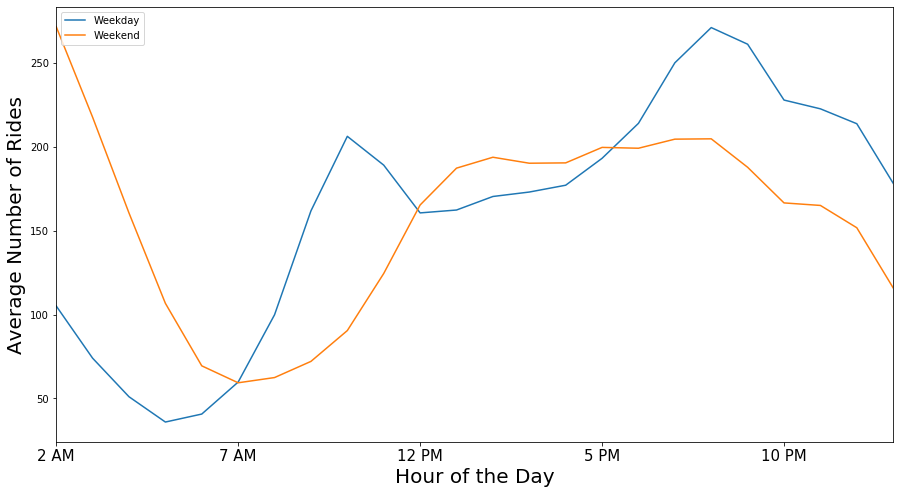

In [39]:
# plot by hour of day and weekday_type

plt.figure(figsize=(15,8))
plt.title('', fontsize=15)
sns.lineplot(weekday_hour['hour'],
             weekday_hour['rides'],
             data=weekday_hour,
             hue=weekday_hour[''])
plt.legend(loc='upper left')
plt.xticks(ticks = np.linspace(0,25,6),
           labels= ['2 AM', '7 AM','12 PM','5 PM','10 PM'],
           fontsize=15)
plt.ylabel('Average Number of Rides', fontsize=20)
plt.xlabel('Hour of the Day', fontsize=20)
plt.xlim(0,23)
plt.savefig(fname='hourly.png', transparent=True)
plt.title;

In [43]:
community_boundaries.area_numbe = community_boundaries.area_numbe.astype('float64')

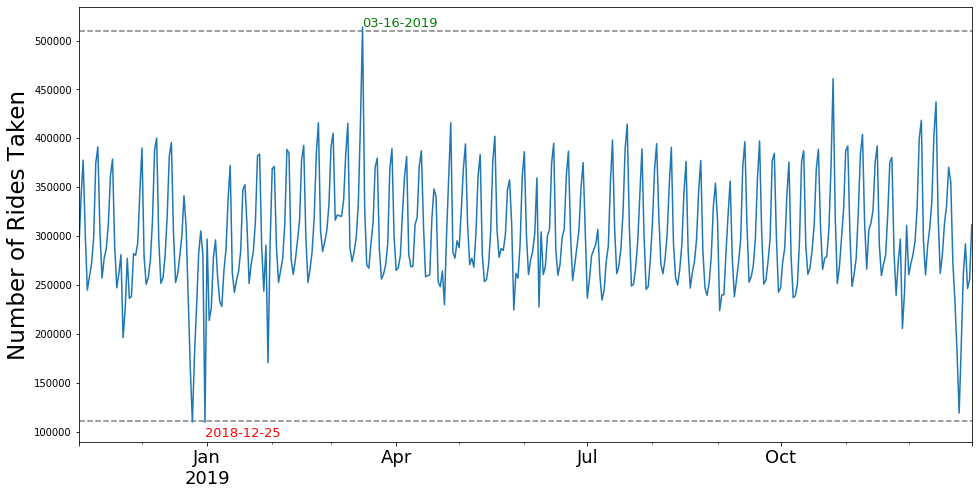

In [44]:
# plot all rides in dataframe by day

daily_totals = community_df.groupby('date').agg({'rides':'sum'})

max_ride = daily_totals[daily_totals.rides == daily_totals.rides.max()]
min_ride = daily_totals[daily_totals.rides == daily_totals[:-1].rides.min()]

daily_totals.plot(figsize=(16,8), label=['total rides'])
plt.title('')

plt.text(max_ride.index[0], max_ride['rides'], max_ride.index[0].strftime('%m-%d-%Y'), color='green', fontsize=13)
plt.hlines(max_ride['rides']-4000,0,100000, linestyles='dashed', alpha=.5)

plt.text(min_ride.index[0], min_ride['rides']-15000, '2018-12-25', color='red', fontsize=13)
plt.hlines(min_ride['rides']+1000,0,100000, linestyles='dashed', alpha=.5)

plt.ylabel('Number of Rides Taken', fontsize=23)


plt.xlabel('')
plt.xticks(fontsize=18)
plt.legend([])

plt.savefig('all_rides',transparent=True)
plt.legend().remove();

In [47]:
# create a per-day df
daily_pickup_df = community_df.groupby(['date',
                              'pickup_community_area']).agg({'rides':'sum'}).\
reset_index().sort_values('date', ascending=False)

In [133]:
# daily_pickup_df.to_pickle('daily_df.pickle')

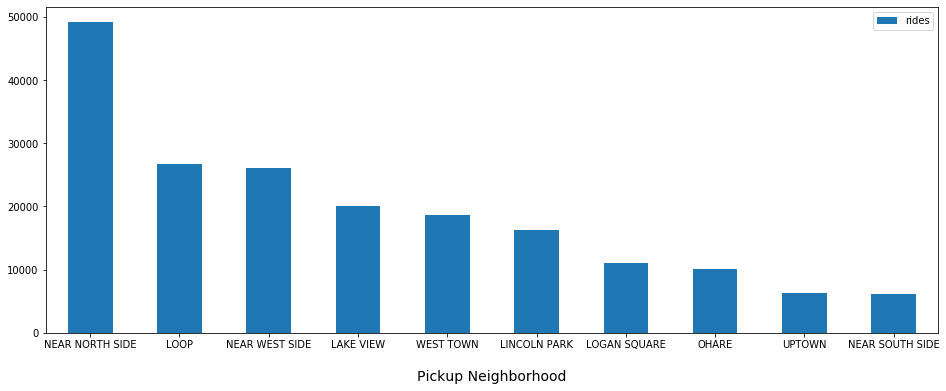

In [536]:
# areas with most rides
daily_pickup_df.groupby('community').agg({'rides':'mean'}).sort_values('rides', ascending=False).head(10).plot(kind='bar', figsize=(16,6))
plt.xticks(rotation=0)
plt.xlabel('Pickup Neighborhood', fontsize=14, labelpad=20);
plt.savefig('neighborhoods.png', transparent=True)

In [30]:
community_boundaries.area_numbe = community_boundaries.area_numbe.astype('float64')

to_keep = ['the_geom', 'area_numbe', 'community']

daily_pickup_df = daily_pickup_df.merge(community_boundaries[to_keep],
                                        how='left',
                                        left_on='pickup_community_area',
                                        right_on='area_numbe').drop(columns=['area_numbe'])

In [56]:
# function to help reduce file size - DEFUNCT: ONLY NEEDED WHEN LOADING INDIVIDUAL RIDES
# def shrink_df(df):
#     df.date = pd.to_datetime(df.date)
#     df.hour = df.hour.astype('int16')
#     df.pickup_community_area = df.pickup_community_area.astype('float16')
#     df.dropoff_community_area = df.dropoff_community_area.astype('float16')
#     df.total_fare = df.total_fare.astype('float32')
#     df.avg_fare = df.avg_fare.astype('float32')
#     df.total_miles = df.total_miles.astype('float32')
#     df.avg_trip_mile = df.avg_trip_mile.astype('float32')
#     df.rides = df.rides.astype('int16')
    
#     return daily_pickup_df

In [57]:
# daily_pickup_df = shrink_df(daily_pickup_df)

# Weather

In [62]:
# load weather to use as an exogenous variable in modeling
%time weather_df = sq.get_weather('2018-10-31', '2020-01-01')

loading pickle!
CPU times: user 6.4 ms, sys: 3.06 ms, total: 9.46 ms
Wall time: 11.9 ms


In [63]:
weather_df.head(5)

,time,summary,icon,precipIntensity,precipProbability,precipType,temperature,apparentTemperature,dewPoint,humidity,pressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,ozone,precipAccumulation
0,2018-10-31 05:00:00,Light Rain,rain,0.0912,0.74,rain,54.00,54.00,53.00,0.96,1008.0,5.16,7.01,348,1.00,0,5.128,272.7,NaN
1,2018-10-31 06:00:00,Rain,rain,0.1095,0.69,rain,52.59,52.59,51.89,0.97,1007.8,5.84,8.42,359,1.00,0,5.620,274.1,NaN
2,2018-10-31 07:00:00,Light Rain,rain,0.0823,0.72,rain,50.56,50.56,50.56,1.00,1008.1,6.78,10.94,355,1.00,0,5.815,274.2,NaN
3,2018-10-31 08:00:00,Light Rain,rain,0.0800,0.77,rain,51.07,51.07,50.46,0.98,1008.8,8.04,12.46,344,0.99,0,5.520,274.2,NaN
4,2018-10-31 09:00:00,Light Rain,rain,0.0661,0.72,rain,50.85,50.85,49.60,0.95,1009.7,7.53,13.25,342,1.00,0,8.966,274.8,NaN


In [66]:
number_cols = [x for x in weather_df.columns if weather_df[x].dtype != object]

weather_df.dtypes 

time                   datetime64[ns]
summary                        object
icon                           object
precipIntensity               float64
precipProbability             float64
precipType                     object
temperature                   float64
apparentTemperature           float64
dewPoint                      float64
humidity                      float64
pressure                      float64
windSpeed                     float64
windGust                      float64
windBearing                     int64
cloudCover                    float64
uvIndex                         int64
visibility                    float64
ozone                         float64
precipAccumulation            float64
dtype: object

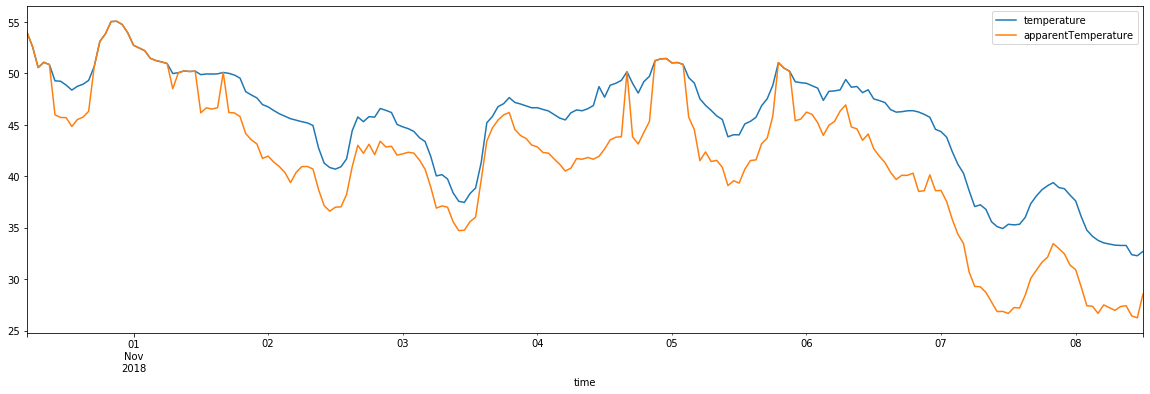

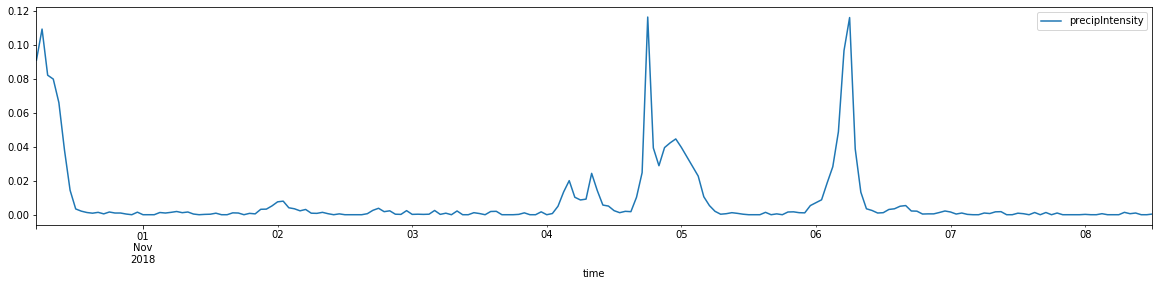

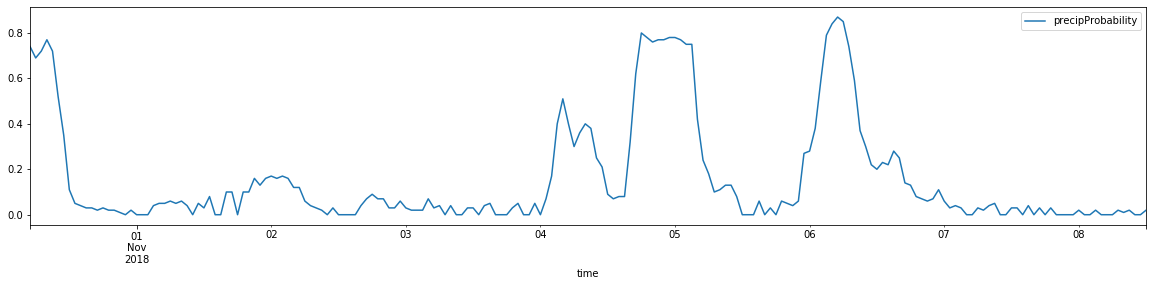

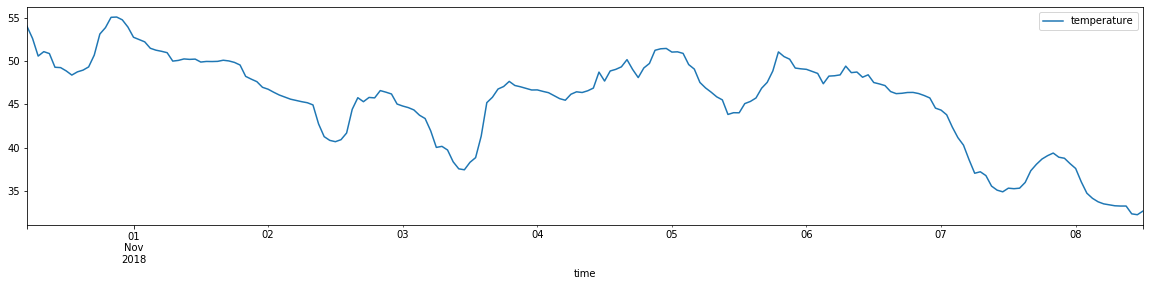

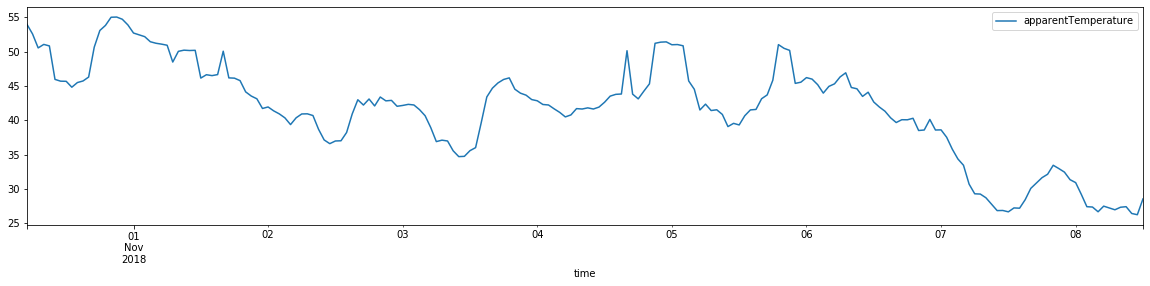

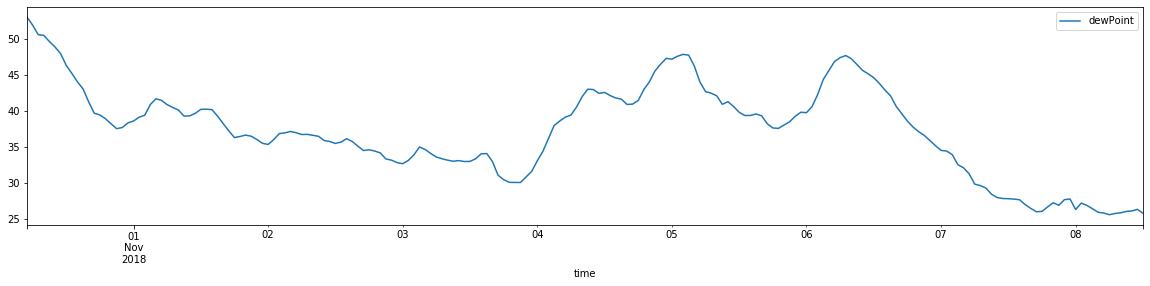

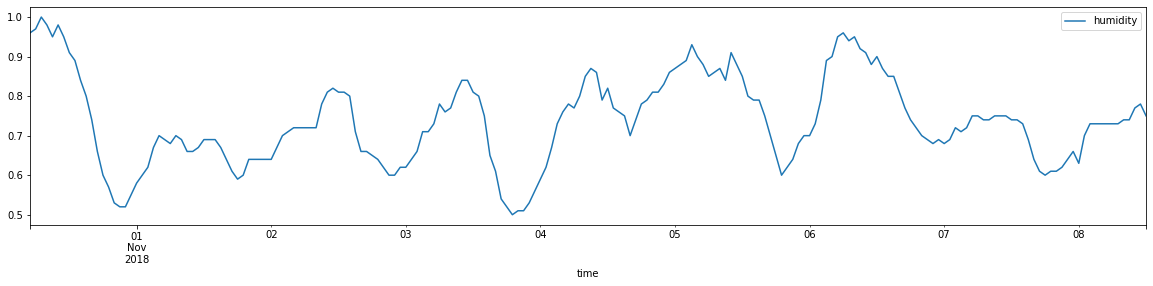

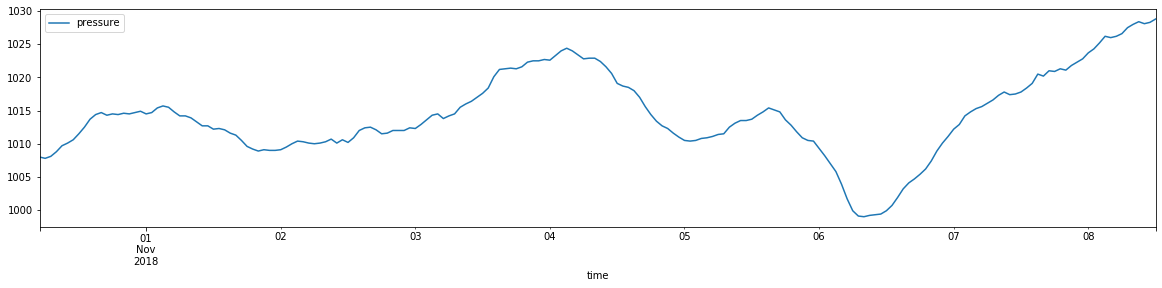

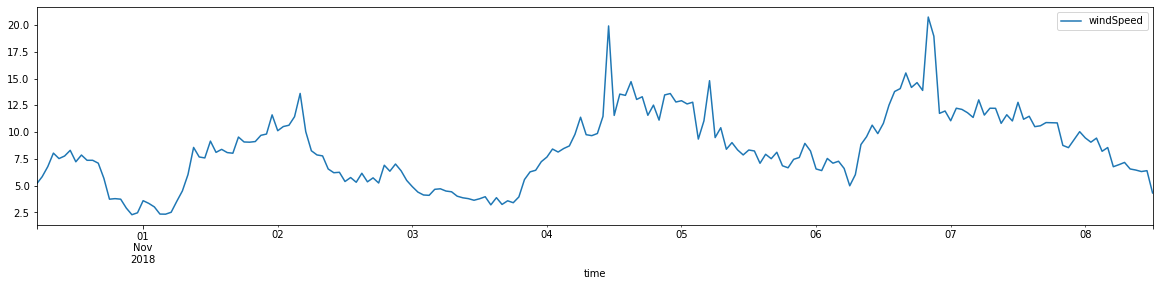

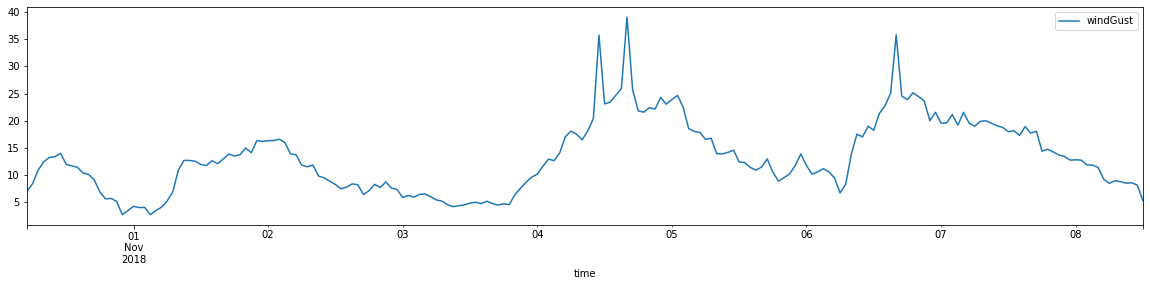

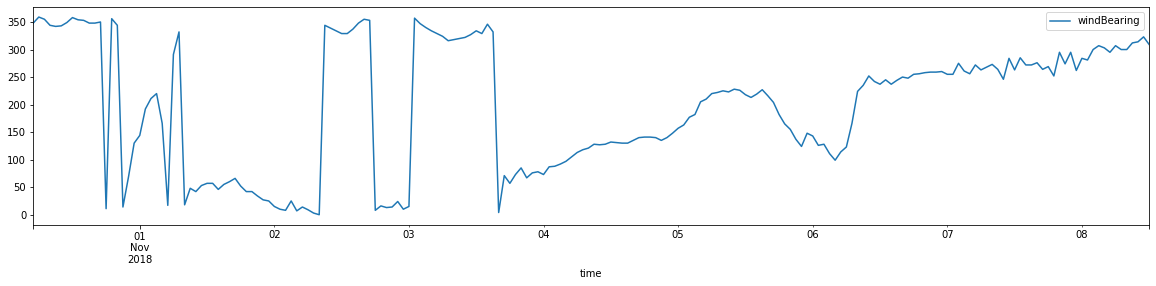

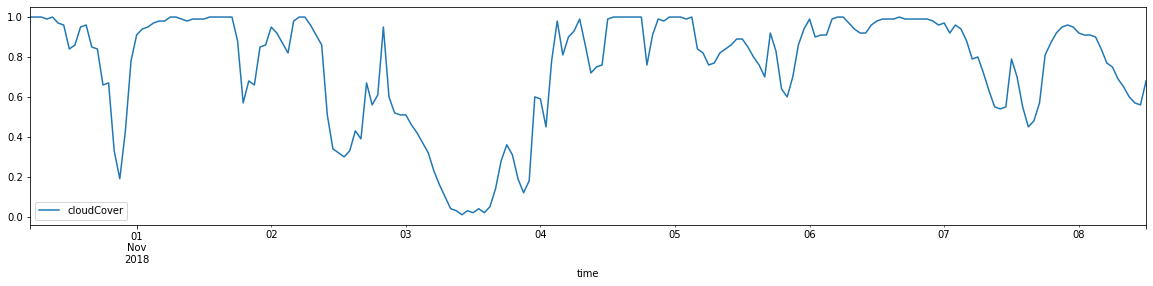

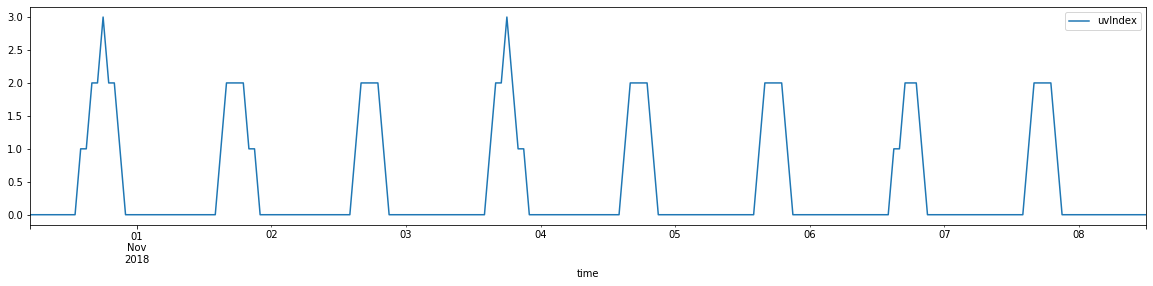

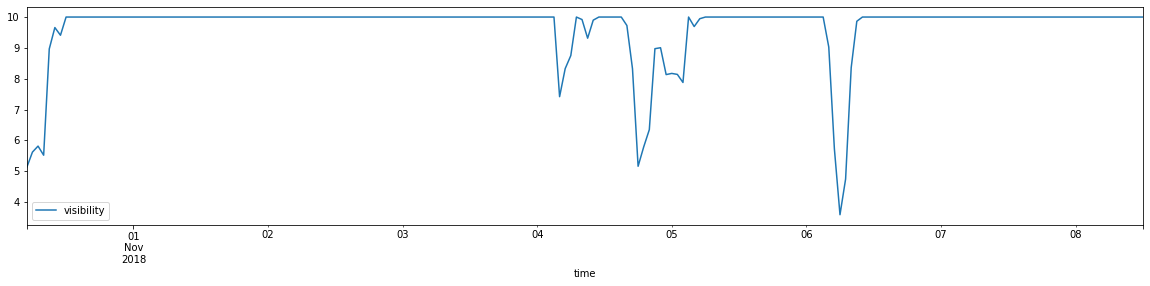

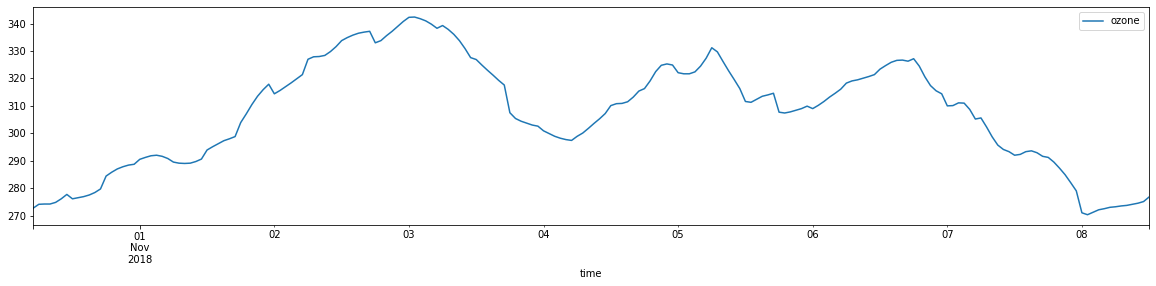

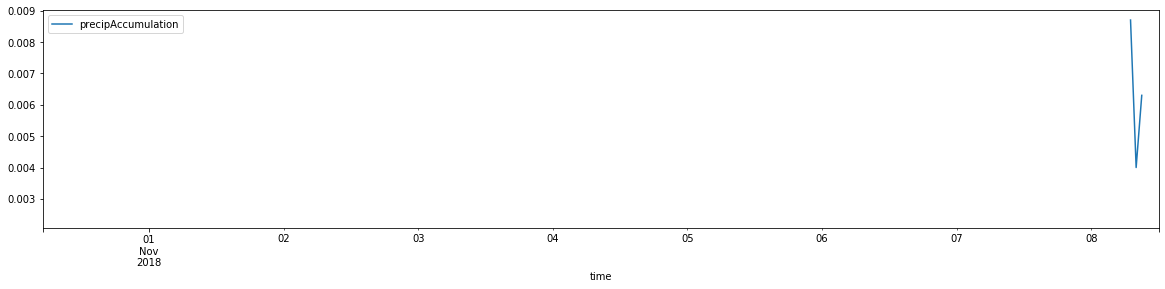

In [67]:
# show temp vs. apparent temp
weather_df.groupby('time').agg({'temperature':'mean',
                               'apparentTemperature': 'mean'})[:200].plot(figsize=(20,6))

# plot each numerical column, showing change over time
for col in weather_df.columns:
    col_type = weather_df[col].dtype
    if col_type == int or col_type == float:
        weather_df[:200].groupby('time').agg({col:'mean'}).plot(figsize=(20,4))

# Merging

In [659]:
merged_daily = community_df.groupby('date_time').agg({'total_fare':'sum',
                                                      'avg_fare':'sum',
                                                      'total_miles':'sum',
                                                      'avg_trip_mile':'sum',
                                                      'rides':'sum'}).reset_index().set_index('date_time')

merged_daily = merged_daily.merge(weather_df.set_index('time').fillna(0),
                                  left_index=True,
                                  right_index=True)

In [661]:
merged_daily.summary.unique(), merged_daily.icon.unique()

(array(['Overcast', 'Partly Cloudy', 'Mostly Cloudy', 'Clear',
        'Possible Drizzle', 'Possible Light Rain',
        'Possible Drizzle and Windy', 'Rain', 'Light Rain',
        'Possible Light Snow', 'Possible Flurries', 'Drizzle',
        'Snow and Windy', 'Snow', 'Light Snow', 'Foggy',
        'Windy and Overcast', 'Windy and Mostly Cloudy',
        'Windy and Partly Cloudy', 'Windy', 'Humid',
        'Humid and Mostly Cloudy', 'Humid and Partly Cloudy'], dtype=object),
 array(['cloudy', 'partly-cloudy-day', 'partly-cloudy-night', 'clear-day',
        'clear-night', 'rain', 'snow', 'fog', 'wind'], dtype=object))

In [663]:
merged_daily.to_pickle('merged_daily.pickle')

# Scooters

In [127]:
%time scooter_df = sq.get_scooters()

calling API!
saved to pickle!
CPU times: user 22.2 s, sys: 2.55 s, total: 24.7 s
Wall time: 48.6 s


In [129]:
scooter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 710839 entries, 0 to 710838
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   trip_id                      710839 non-null  object
 1   start_time                   710839 non-null  object
 2   end_time                     710839 non-null  object
 3   trip_distance                710839 non-null  object
 4   trip_duration                710839 non-null  object
 5   accuracy                     710839 non-null  object
 6   start_community_area_number  613450 non-null  object
 7   end_community_area_number    612923 non-null  object
 8   start_community_area_name    613450 non-null  object
 9   end_community_area_name      612923 non-null  object
 10  start_centroid_latitude      613451 non-null  object
 11  start_centroid_longitude     613451 non-null  object
 12  start_centroid_location      613451 non-null  object
 13  end_centroid_l

In [130]:
def get_coords(x):
    if type(x) == dict:
        coords = x['coordinates']
    else:
        coords = None
        
    return coords

In [132]:
scooter_df['start_centroid_location'] = scooter_df['start_centroid_location'].map(lambda x: get_coords(x))
scooter_df['end_centroid_location'] = scooter_df['end_centroid_location'].map(lambda x: get_coords(x))

In [133]:
scooter_df.sample(1)

,trip_id,start_time,end_time,trip_distance,trip_duration,accuracy,start_community_area_number,end_community_area_number,start_community_area_name,end_community_area_name,start_centroid_latitude,start_centroid_longitude,start_centroid_location,end_centroid_latitude,end_centroid_longitude,end_centroid_location,start_census_tract,end_census_tract
182890,d6561332-8a17-4493-9cba-9c6e4c0ec9c0,2019-07-07T10:00:00.000,2019-07-07T10:00:00.000,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,None,NaN,NaN


In [134]:
[x for x in scooter_df.end_community_area_name.unique() if x not in scooter_df.start_community_area_name.unique()]

[nan,
 'LAKE VIEW',
 'GARFIELD RIDGE',
 'JEFFERSON PARK',
 'ALBANY PARK',
 'MCKINLEY PARK',
 'ARCHER HEIGHTS',
 'LINCOLN SQUARE',
 'KENWOOD',
 'WEST RIDGE',
 'CHICAGO LAWN',
 'WEST ENGLEWOOD',
 'NORWOOD PARK']

In [135]:
community_areas = scooter_df.groupby(['start_community_area_name',
                    'end_community_area_name']).agg({'start_centroid_latitude':'max',
                                                     'start_centroid_longitude': 'max',
                                                     'end_centroid_latitude':'max',
                                                     'end_centroid_longitude': 'max',
                                                    'trip_id':'count'}).reset_index()

In [136]:
community_areas

,start_community_area_name,end_community_area_name,start_centroid_latitude,start_centroid_longitude,end_centroid_latitude,end_centroid_longitude,trip_id
0,ARMOUR SQUARE,ARMOUR SQUARE,41.8420774867429,-87.6339736975322,41.8420774867429,-87.6339736975322,1
1,AUSTIN,ALBANY PARK,41.8941012961134,-87.7631118242259,41.9680684656836,-87.7215597838681,1
2,AUSTIN,AUSTIN,41.9146186588449,-87.7967955436002,41.9146186588449,-87.7967955436002,14535
3,AUSTIN,AVONDALE,41.9129077726091,-87.7753955652535,41.9428681074369,-87.7302981167554,42
4,AUSTIN,BELMONT CRAGIN,41.9146186588449,-87.7967955436002,41.9352176386575,-87.7880224758376,1236
...,...,...,...,...,...,...,...
406,WEST TOWN,UPTOWN,41.9012067343156,-87.6763571260391,41.9658120777132,-87.6558793191515,2
407,WEST TOWN,WEST GARFIELD PARK,41.9012067343156,-87.6763571260391,41.8785946681995,-87.7302325118985,38
408,WEST TOWN,WEST TOWN,41.9147877430097,-87.7018836562075,41.9147877430097,-87.7018836562075,138175
409,WOODLAWN,NEAR WEST SIDE,41.7788764106426,-87.5949253613625,41.8740053848845,-87.6635178867003,2


In [137]:
scooter_df['start_census_tract'].unique()[:10]

array([nan, '17031833100', '17031241500', '17031241400', '17031242100',
       '17031833000', '17031241600', '17031240200', '17031831000',
       '17031242200'], dtype=object)

In [138]:
scooter_df['start_community_area_name'].unique()

array(['LOWER WEST SIDE', 'WEST TOWN', 'WEST GARFIELD PARK',
       'NEAR WEST SIDE', 'LOGAN SQUARE', 'AUSTIN', nan, 'NORTH LAWNDALE',
       'AVONDALE', 'PORTAGE PARK', 'MONTCLARE', 'IRVING PARK', 'DUNNING',
       'HUMBOLDT PARK', 'BELMONT CRAGIN', 'EAST GARFIELD PARK', 'HERMOSA',
       'NEAR NORTH SIDE', 'SOUTH LAWNDALE', 'NORTH CENTER', 'BRIDGEPORT',
       'LINCOLN PARK', 'LOOP', 'OHARE', 'BRIGHTON PARK', 'NEW CITY',
       'UPTOWN', 'WOODLAWN', 'NEAR SOUTH SIDE', 'ARMOUR SQUARE',
       'GAGE PARK'], dtype=object)

In [140]:
scooter_df.groupby('start_time').count()

,trip_id,end_time,trip_distance,trip_duration,accuracy,start_community_area_number,end_community_area_number,start_community_area_name,end_community_area_name,start_centroid_latitude,start_centroid_longitude,start_centroid_location,end_centroid_latitude,end_centroid_longitude,end_centroid_location,start_census_tract,end_census_tract
start_time,,,,,,,,,,,,,,,,,
2019-06-15T04:00:00.000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
2019-06-15T06:00:00.000,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,3,3
2019-06-15T07:00:00.000,38,38,38,38,38,36,36,36,36,36,36,36,36,36,36,21,21
2019-06-15T08:00:00.000,59,59,59,59,59,54,54,54,54,54,54,54,54,54,54,23,23
2019-06-15T09:00:00.000,193,193,193,193,193,178,178,178,178,178,178,178,178,178,178,103,103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-15T20:00:00.000,167,167,167,167,167,138,138,138,138,138,138,138,138,138,138,43,43
2019-10-15T21:00:00.000,103,103,103,103,103,84,84,84,84,84,84,84,84,84,84,20,20
2019-10-15T22:00:00.000,54,54,54,54,54,48,48,48,48,48,48,48,48,48,48,7,7


In [141]:
scooter_df.groupby('start_community_area_name').count()

,trip_id,start_time,end_time,trip_distance,trip_duration,accuracy,start_community_area_number,end_community_area_number,end_community_area_name,start_centroid_latitude,start_centroid_longitude,start_centroid_location,end_centroid_latitude,end_centroid_longitude,end_centroid_location,start_census_tract,end_census_tract
start_community_area_name,,,,,,,,,,,,,,,,,
ARMOUR SQUARE,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
AUSTIN,19277,19277,19277,19277,19277,19277,19277,18852,18852,19277,19277,19277,18852,18852,18852,2770,2664
AVONDALE,17503,17503,17503,17503,17503,17503,17503,17499,17499,17503,17503,17503,17499,17499,17499,5502,5500
BELMONT CRAGIN,20563,20563,20563,20563,20563,20563,20563,20499,20499,20563,20563,20563,20499,20499,20499,4612,4590
BRIDGEPORT,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,7,7
BRIGHTON PARK,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
DUNNING,1766,1766,1766,1766,1766,1766,1766,1745,1745,1766,1766,1766,1745,1745,1745,318,311
EAST GARFIELD PARK,7467,7467,7467,7467,7467,7467,7467,7457,7457,7467,7467,7467,7457,7457,7457,2159,2155
GAGE PARK,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0


In [145]:
to_from_df = scooter_df.groupby(['start_community_area_name',
                                 'end_community_area_name']).\
agg({'trip_id':'count'}).reset_index()

to_from_df

,start_community_area_name,end_community_area_name,trip_id
0,ARMOUR SQUARE,ARMOUR SQUARE,1
1,AUSTIN,ALBANY PARK,1
2,AUSTIN,AUSTIN,14535
3,AUSTIN,AVONDALE,42
4,AUSTIN,BELMONT CRAGIN,1236
...,...,...,...
406,WEST TOWN,UPTOWN,2
407,WEST TOWN,WEST GARFIELD PARK,38
408,WEST TOWN,WEST TOWN,138175
409,WOODLAWN,NEAR WEST SIDE,2


# Community Areas

#### working with geojson

In [81]:
from geojson import LineString
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [110]:
def get_coords(polygon):
    
    if type(polygon) == dict:
        coords = polygon['coordinates'][0][0]
    else:
        coords = None
        
    return coords

In [113]:
community_boundaries['coords'] = community_boundaries.the_geom.map(lambda x: get_coords(x))

In [114]:
community_boundaries.head(1)

,the_geom,perimeter,area,comarea,comarea_id,area_numbe,community,area_num_1,shape_area,shape_len,coords
0,"{'type': 'MultiPolygon', 'coordinates': [[[[-8...",0,0,0,0,35.0,DOUGLAS,35,46004621.1581,31027.0545098,"[[-87.60914087617894, 41.84469250265398], [-87..."


In [115]:
polygon = Polygon(community_boundaries['coords'][0]) # create polygon

In [119]:
# show length
print(f'polygon length: {polygon.length}')

# try to simplify area
print(f'simplified polygon: {polygon.simplify(.1).length}')

polygon length: 0.09912869105511067
simplified polygon: 0.08488400199202391


In [120]:
point = Point(-87.616571834701, 41.84563904253) # create point

In [121]:
print(polygon.contains(point)) # check if polygon contains point
print(point.within(polygon)) # check if a point is in the polygon 

True
True
